### Расчётно-графическая работа №3
*Выполнил студент группы R3341 Овчинников Павел (вариант №1)*

---

Для каждой проблемы нужно провести два статистических теста, если не сказано иное, причём первый из критериев нужно реализовать самостоятельно (считать и выводить значение статистики, критическое значение, p-value), в качестве второго можно воспользоваться готовой реализацией. Также нужно отдельно указывать, как формализуются $H_0$ и $H_1$ для выбранных тестов. Уровень значимости выбирается самостоятельно.


В файл `kc_house_data.csv` приведены данные о цене на недвижимость где-то в окрестности Сиэтла.

**Задания:**
1. Предположить, с каким вероятностным законом распределена цена. С помощью стат.теста подтвердить или опровергнуть своё предположение.
2. Верно ли, что цена на старый и новый фонд распределена одинаково? (порог возраста выбрать самостоятельно)
3. Верно ли, что при увеличении «жилищной площади» растёт и цена?

In [17]:
# Импортируем необходимые модули
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm

Считаем данные:

In [18]:
data = pd.read_csv('kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Построим гистограмму цены и выдвинем гипотезу о том, по какому закону она распределена:

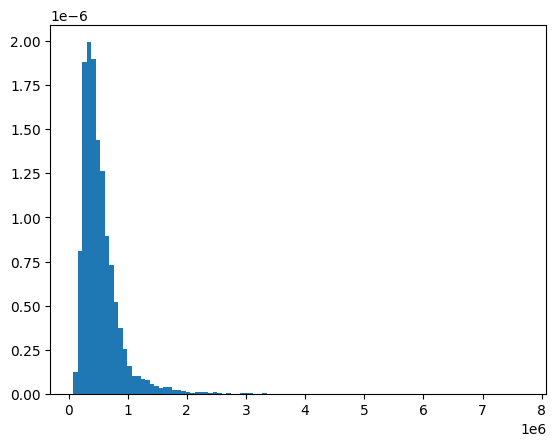

In [19]:
price = data['price']
plt.hist(price, bins=100, density=True)
plt.show()

Итак, введём следующую гипотезу о распределении:
- $H_0$: цена распределена по закону логнормального распределения
- $H_1$: цена не распределена по закону логнормального распределения

Проверим гипотезу с помощью критерия согласия Пирсона:
$$\chi^2 = \sum\frac{(\hat{n}_i - n_i)^2}{n_i}$$
Здесь $\hat{n}_i$ — эмпирическая частота, то есть частоты из выборки, а $n_i$ — теоретическая частота, то есть частоты, которые мы ожидаем, если бы гипотеза $H_0$ была верна.

Уровень значимости зафиксируем в 0.05, как это часто и бывает.

In [20]:
alpha = 0.05

mu = np.mean(np.log(price))
sigma = np.std(np.log(price))
hat_n, bins = np.histogram(price, 'auto')
n = (bins[1] - bins[0]) * len(price) * stats.lognorm.pdf(bins[:-1], sigma, scale=np.exp(mu))  # теоретическая частота
f = len(hat_n) - 3  # число степеней свободы

chi2 = np.sum((hat_n - n) ** 2 / n)  # статистика критерия
p_value = 1 - stats.chi2.cdf(chi2, f)
critical_value = stats.chi2.ppf(1 - alpha, f)

print(f'{chi2=}, {p_value=}, {critical_value=}')
assert chi2 < critical_value, 'Гипотеза неверна'

chi2=np.float64(55471.5148713883), p_value=np.float64(0.0), critical_value=np.float64(369.10609722763786)


AssertionError: Гипотеза неверна

Проверим гипотезу в том числе и с помощью критерия Колмогорова-Смирнова.

In [ ]:
ks, p_value = stats.kstest(price, 'lognorm', (sigma, np.exp(mu)))

print(f'{ks=}, {p_value=}')
assert p_value >= alpha, 'Гипотеза неверна'

ks=np.float64(0.5212603525655856), p_value=np.float64(0.0)


AssertionError: Гипотеза неверна

Итак, гипотеза неверна при двух стат.тестах, значит цена не распределена по закону логнормального распределения.

---

Рассмотрим две новые гипотезы:
- $H_0$: цена на старый и новый фонд распределена одинаково
- $H_1$: цена на старый и новый фонд распределена по-разному

Критическим возьмём значение в 2000 — всё, что меньше, относится к старому фонду, всё, начиная с этого года — к новому. И разделим датасет на две части.

In [9]:
crit = 2000
old_price = data[data['yr_built'] < crit]['price']
new_price = data[data['yr_built'] >= crit]['price']

Проверим гипотезу с помощью критерия согласия Пирсона для двух независимых выборок:
$$\chi^2 = n_1n_2\sum_{i=1}^{r}\frac{\left(\frac{m_i}{n_1} - \frac{l_i}{n_2}\right)}{m_i+l_i},$$
где $m_i$ и $l_i$ — частоты встречаемости $i$-го значения в первой и второй выборках соответственно, $n_1$ и $n_2$ — размеры выборок.

In [10]:
n1, n2 = len(old_price), len(new_price)

m, _ = np.histogram(old_price, 15)
l, _ = np.histogram(new_price, 15)
f = len(l) - 1  # число степеней свободы

chi2 = n1 * n2 * np.sum((l / n1 - m / n2) ** 2 / (m + l))  # статистика критерия
p_value = 1 - stats.chi2.cdf(chi2, f)
critical_value = stats.chi2.ppf(1 - alpha, f)

print(f'{chi2=}, {p_value=}, {critical_value=}')
assert chi2 < critical_value, 'Гипотеза неверна'

chi2=np.float64(39586.35210107894), p_value=np.float64(0.0), critical_value=np.float64(23.684791304840576)


AssertionError: Гипотеза неверна

Распределения не совпадают, так как значение статистики $\chi^2$ больше критического значения. Теперь перейдём к критерию Колмогорова-Смирнова.

In [ ]:
ks, p_value = stats.ks_2samp(old_price, new_price)

print(f'{ks=}, {p_value=}')
assert p_value >= alpha, 'Гипотеза неверна'

ks=np.float64(0.15215404572296398), p_value=np.float64(1.7763663434258002e-75)


AssertionError: Гипотеза неверна

Согласно критерию Колмогорова-Смирнова, гипотеза о равенстве распределений также отвергается.

---

Чтобы выяснить, коррелирует ли жилищная площадь с ценой, для начал выделим необходимые нам столбцы и визуализируем зависимость, чтобы выдвинуть гипотезу.

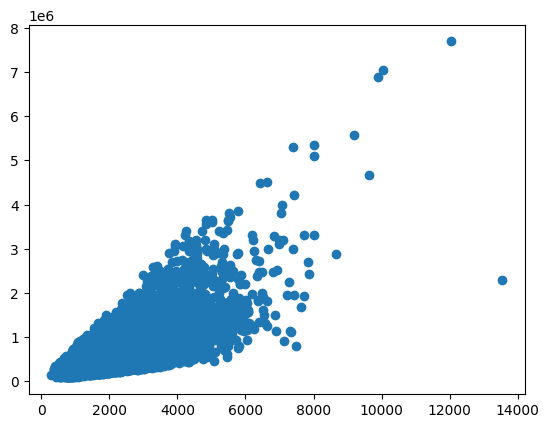

In [12]:
living_sqfts = data[['sqft_living', 'price']]

plt.scatter(living_sqfts['sqft_living'], living_sqfts['price'])
plt.show()

Визуально по точечной диаграмме можно сказать, что зависимость есть, но проверим статистически. Введём следующую гипотезу:
- $H_0$: при увеличении жилищной площади цена не растёт ($r = 0$)
- $H_1$: при увеличении жилищной площади цена растёт ($r > 0$)

Проверим гипотезу с помощью корреляции Пирсона, которая как раз рассчитывает коэффициент линейной корреляции между двумя наборами данных:
$$r = \frac{\overline{XY} - \overline{X}\overline{Y}}{\sqrt{\left(\overline{X^2} - \overline{X}^2\right)\left(\overline{Y^2} - \overline{Y}^2\right)}}$$

Реализуем корреляцию самостоятельно.

In [13]:
x, y = living_sqfts['sqft_living'], living_sqfts['price']
x_mean, y_mean = np.mean(x), np.mean(y)

r = np.sum((x - x_mean) * (y - y_mean)) / np.sqrt(np.sum((x - x_mean) ** 2) * np.sum((y - y_mean) ** 2))
r

np.float64(0.7020350546118)

Выполним расчёт p-value с использованием t-теста (зафиксируем значимость в 0.05), используя следующую формулу:
$$t = r \sqrt{\frac{n-2}{1-r^2}}$$

In [14]:
n = len(living_sqfts)
t = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
f = n - 2  # число степеней свободы
p_value = 1 - stats.t.cdf(t, f)

print(f'{t=}, {p_value=}')
assert p_value < alpha, 'Гипотеза неверна'

t=np.float64(144.9203561982449), p_value=np.float64(0.0)


Гипотеза о том, что при увеличении жилищной площади цена растёт, подтверждается, так как p-value меньше уровня значимости.

Проверим также с помощью готовой реализации линейной регрессии (или метода наименьших квадратов).

In [16]:
x = sm.add_constant(x)

linear_model = sm.OLS(y, x).fit()

assert linear_model.pvalues.iloc[1] < alpha, 'Гипотеза неверна'

Код отработал корректно — это значит, что мы отвергаем нулевую гипотезу.